In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [72]:
import os
import copy
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch_geometric.data import Data, DataLoader

import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn as nn
from torch_geometric.nn import *


warnings.filterwarnings('ignore')

In [73]:
class Config:
    seed = 0
    learning_rate = 0.001
    weight_decay = 1e-5
    input_dim = 165
    output_dim = 1
    hidden_size = 128
    num_layers = 3
    num_epochs = 100
    checkpoints_dir = './models/elliptic_gnn'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Using device:", Config.device)

Using device: cuda


In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
# DATA LOADING/PREPARATION
df_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})

In [76]:
print(df_features.shape)
df_features.head()

(203769, 167)


,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [77]:
print(df_edges.shape)
df_edges.head()

(234355, 2)


,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [78]:
# Hay dos problemas:
# - Está desbalanceado y hay que oversamplear la clase 1 para que iguale las muestras de la clase 0.
# - La clase 2 es desconocida por lo que solo aporta ruido. Hay que eliminar todo rastro de esa clase antes de oversampling
print(df_classes['class'].value_counts())


2    157205
0     42019
1      4545
Name: class, dtype: int64


In [79]:
# PASO 1: Eliminar todo rastro de la clase desconocida '2' para evitar ruido y poder oversamplear
# 1.1 Quitamos los nodos con clase 2 del df_classes
# Quitamos los nodos de la clase desconocida
df_classes2 = df_classes[df_classes['class'] != 2 ]
print(df_classes2.shape)
print(df_classes2['class'].value_counts())



(46564, 2)
0    42019
1     4545
Name: class, dtype: int64


In [80]:
# 1.2 Quitamos los nodos con clase 2 del df_features. Hacemos join con df_classes para saber la clase y suprimirla
print("df_features antes: ", df_features.shape)
df_features2 = pd.merge(df_features,df_classes2,how='inner', left_on=[0], right_on=['txId']).drop(['txId'], axis=1)
print("df_features despues: ", df_features2.shape)
df_features2.head()

df_features antes:  (203769, 167)
df_features despues:  (46564, 168)


,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
3,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
4,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,0


In [81]:
# 1.3 Quitamos todas las aristas que tengan algo que ver con la clase 2. Lo hacemos mediante 2 outer joins (uno contra los nodos origen y otro contra los nodos destino) de la clase desconocida
# Quitamos los edges donde están involucrados nodos de la clase desconocida
print("df_edges antes: ", df_edges.shape)
df_classes_unknown = df_classes.loc[df_classes['class'] == 2, 'txId']
print("Número de nodos pertenecientes a la clase desconocida: ", df_classes_unknown.shape)
df_edges2 = pd.merge(df_classes_unknown, df_edges, indicator=True, how = 'outer', left_on=['txId'], right_on=['txId1']).query('_merge=="right_only"').drop(['txId', '_merge'], axis=1)
print("df_edges sin clase 2 en los nodos origen: ", df_edges2.shape)
df_edges2 = pd.merge(df_classes_unknown, df_edges2, indicator=True, how = 'outer', left_on=['txId'], right_on=['txId2']).query('_merge=="right_only"').drop(['txId', '_merge'], axis=1)
print("df_edges sin clase 2 en los nodos origen ni destino: ", df_edges2.shape)
df_edges2.head()
df_edges2 = df_edges2.astype(int)
# Vemos que una vez se ha eliminado todo rastro de la clase 2, nos encontramos con que hay menos aristas que nodos de las clase 0 y 1 juntas: 36624 vs 46564

df_edges antes:  (234355, 2)
Número de nodos pertenecientes a la clase desconocida:  (157205,)
df_edges sin clase 2 en los nodos origen:  (53198, 2)
df_edges sin clase 2 en los nodos origen ni destino:  (36624, 2)


In [82]:
# PASO 2: Una vez se ha "limpiado" la clase 2, es necesario fusionar los dfs para tener una única tabla que será la entrada del SMOTE (oversampler)
# 2.1 Añadimos al df_features la columna de clase. Debería resultar en un mismo número de filas (df_features2)

# 2.2 Añadimos la columna 'destino' al df_features (alias txId2).
# El resultado será un aumento en el número de filas ya que un nodo puede ser origen de varias aristas.
# Convertimos los NaN a 0 para no tener problemas. Los NaN solo aparecerán en la columna 'destino' porque hay nodos que no son origen de ninguna arista
df_join = pd.merge(df_features2, df_edges2, how = 'left', left_on=[0], right_on=['txId1']).drop('txId1', axis=1).drop_duplicates()
df_join['txId2'].fillna(0, inplace=True)
print("El df resultado tiene la siguiente forma: ", df_join.shape)
print("La distribución de clase en formato tabular seria:\n",df_join['class'].value_counts())
df_join.head()

El df resultado tiene la siguiente forma:  (56045, 169)
La distribución de clase en formato tabular seria:
 0    51362
1     4683
Name: class, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,class,txId2
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0,92491280.0
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0,5119722.0
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0,27553029.0
3,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0,234419685.0
4,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0,230411688.0


In [83]:
# PASO 3. Una vez tenemos los datos en forma tabular, los dividimos para la entrada en el oversampler:
X = df_join.rename(columns={'txId2':len(df_join.columns)-2}).drop('class', axis=1)
y = df_join['class']
print("La entrada X tendría la siguiente forma: ", X.shape)
print("La entrada y tendría la siguiente forma: ", y.shape)
print("Distribución de y:\n", y.value_counts())
X.head()

La entrada X tendría la siguiente forma:  (56045, 168)
La entrada y tendría la siguiente forma:  (56045,)
Distribución de y:
 0    51362
1     4683
Name: class, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,92491280.0
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,5119722.0
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,27553029.0
3,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,234419685.0
4,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230411688.0


In [84]:
# PASO 4. Realizamos el OVERSAMPLING.
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

ss_over = 0.99
ss_under = 0.1

# Definimos las estrategias de oversampling y undersampling
over = SMOTE(sampling_strategy=ss_over)
under = RandomUnderSampler(sampling_strategy=ss_under)

# Combinamos ambas estrategias en un pipeline:
steps = [ ('u', under), ('o', over)]
pipeline = Pipeline(steps=steps)

X_res, y_res = pipeline.fit_resample(X, y)

print("Resultado oversampling y undersampling tabular:\n", y_res.value_counts())


Resultado oversampling y undersampling tabular:
 0    46830
1    46361
Name: class, dtype: int64


In [85]:
# PASO 5. VOLVER AL FORMATO GRAFO
# 5.1 JUNTAMOS dfs para incluir el campo class
print(X_res.shape)
X_res['class'] = y_res
X_res[167] = X_res[167].astype(int)
X_res = X_res.drop_duplicates(subset=[0, 'class'], keep=False)
print(X_res.shape)
X_res.head()

(93191, 168)
(68335, 169)


,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,class
0,248890897,18,-0.160929,9.119861,1.573595,31.093634,-0.063725,29.993542,5.111450,-0.163645,...,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,249110783,0
1,307362615,22,-0.170748,-0.158783,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163637,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0,0
2,245372757,3,-0.138303,-0.092931,0.463609,0.628405,-0.024025,0.641758,-0.061584,-0.163645,...,-0.815598,-0.815112,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0,0
3,269885809,25,-0.122444,-0.072016,0.463609,0.103143,-0.043875,0.138585,-0.061584,-0.162689,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0,0
4,299093243,30,-0.160707,0.141743,0.463609,0.028105,0.194326,0.054722,-0.061584,-0.161516,...,-0.197861,-0.245572,-0.098889,0.162428,0.113250,-0.085217,-0.315309,0.398271,0,0


In [86]:
# 5.2 Reconstruimos df de classes
# 1. Montamos df de classes cogiendo tanto la columna "origen" (txId1 alias 0) como la columna "destino" (txId2 alias 167). Eliminamos todas las apariciones de los nodos con más de 1
df_c_1 = X_res[[0]].drop_duplicates().rename(columns={0:'txId'}).sort_values('txId').reset_index(drop=True)
df_c_2 = X_res[[167]].drop_duplicates().rename(columns={167:'txId'}).sort_values('txId').reset_index(drop=True)
df_nu = pd.concat([df_c_1, df_c_2]).drop_duplicates(subset=['txId'], keep='first')


# 2. Obtenemos las clases de los nodos unicos
df_classes_smute = pd.merge(df_nu, X_res[[0, 'class']], how = 'inner', left_on=['txId'], right_on=[0]).drop([0], axis=1).drop_duplicates(subset=['txId'], keep='first').dropna(how='any').reset_index(drop=True)
print("df_classes_smute: ", df_classes_smute.shape)
print("Distribución df_classes_smute:\n", df_classes_smute['class'].value_counts())

# 3. Obtener el complementario df_classes_smute para mas adelante. Todos los nodos creados pero que o bien tienen varias clases o bien no tienen porque son solo destinos
df_classes_smute_c = pd.merge(df_classes_smute['txId'], df_nu, indicator=True, how='outer', left_on=['txId'], right_on=['txId']).query('_merge=="right_only"'). drop(['_merge'], axis=1).reset_index(drop=True).drop_duplicates(subset=['txId'], keep='first')
print("Complementario df_classes_smute (solo nodos): ", df_classes_smute_c.shape)


df_classes_smute_c.head()



df_classes_smute:  (68279, 2)
Distribución df_classes_smute:
 0    34542
1    33737
Name: class, dtype: int64
Complementario df_classes_smute (solo nodos):  (12632, 1)


,txId
0,0
1,3181
2,8727
3,13646
4,44067


In [87]:
# 5.3 Reconstruimos df de features
df_features_smute = pd.merge(df_classes_smute['txId'], X_res.drop([167, 'class'], axis=1), how = 'inner', left_on=['txId'], right_on=[0]).drop(['txId'], axis=1).drop_duplicates(subset=[0], keep='first').reset_index(drop=True)
print("df_features_smute: ", df_features_smute.shape)
#df_features_smute.head()

#df_classes_smute = pd.merge(df_classes_smute, df_features_smute[0], how='inner', left_on=['txId'], right_on=[0]).drop([0], axis=1).reset_index(drop=True)
print("df_classes_smute: ", df_classes_smute.shape)
#df_features_smute.head()


df_features_smute:  (68279, 167)
df_classes_smute:  (68279, 2)


In [88]:
# 5.4 Reconstruimos df de edges
df_edges_smute1 = pd.merge(df_classes_smute_c, X_res[[0, 167]], indicator=True, how = 'outer', left_on=['txId'], right_on=[0]).query('_merge=="right_only"').drop(['txId', '_merge'], axis=1)
print("df_edges_smute eliminando procesando origenes : ", df_edges_smute1.shape)
df_edges_smute2 = pd.merge(df_classes_smute_c, df_edges_smute1, indicator=True, how = 'outer', left_on=['txId'], right_on=[167]).query('_merge=="right_only"').drop(['txId', '_merge'], axis=1)
print("df_edges_smute procesando origen y destino", df_edges_smute2.shape)
df_edges_smute2 = df_edges_smute2.rename(columns={0:'txId1', 167: 'txId2'}).astype(int).reset_index(drop=True)
df_edges_smute2.head()



df_edges_smute eliminando procesando origenes :  (68335, 2)
df_edges_smute procesando origen y destino (19968, 2)


,txId1,txId2
0,248890897,249110783
1,310437451,310437448
2,155803876,157239536
3,105785078,106311927
4,78789157,118639527


In [89]:
# Cruzamos df_features_smute con df_classes_smute
df_merge = df_features_smute.merge(df_classes_smute, how='inner', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)

# Extraemos nodos no clasificados por si quedara alguno
classified = df_merge.loc[df_merge['class'].loc[df_merge['class']!=2].index].drop('txId', axis=1)
unclassified = df_merge.loc[df_merge['class'].loc[df_merge['class']==2].index].drop('txId', axis=1)

# Extraemos aristas no clasificadas
classified_edges = df_edges_smute2.loc[df_edges_smute2['txId1'].isin(classified[0]) & df_edges_smute2['txId2'].isin(classified[0])]
unclassifed_edges = df_edges_smute2.loc[df_edges_smute2['txId1'].isin(unclassified[0]) | df_edges_smute2['txId2'].isin(unclassified[0])]

In [90]:
# Limpiamos con dropna y reseteamos indices
df_merge = df_merge.dropna()
df_merge = df_merge.reset_index(drop = True)
print(df_merge.shape)
df_merge.head()

(68279, 169)


,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,6418,48,-0.125229,7.538599,2.128587,7.381781,0.095076,7.602324,0.547008,-0.163537,...,-0.197237,0.303447,-0.098889,0.931406,1.041565,0.371499,0.790060,0.779125,6418,0
1,9351,48,-0.172970,-0.114281,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163630,...,1.461330,1.461369,-0.098889,0.662264,1.728088,1.539269,1.519700,1.521399,9351,0
2,9363,48,-0.027465,0.177798,1.573595,-0.121970,0.234026,-0.113002,-0.061584,-0.014750,...,-0.058102,-0.216309,-0.098889,0.662264,0.786576,0.860861,-0.431555,-0.124795,9363,0
3,9466,48,1.366259,8.361870,1.573595,7.381781,1.246377,8.189360,-0.061584,-0.163639,...,0.327278,0.166077,-0.098889,0.912182,0.658165,0.296102,-0.370208,-0.665072,9466,0
4,9551,48,-0.172505,0.186368,1.018602,-0.046932,-0.043875,-0.029140,-0.061584,-0.163639,...,1.461330,1.461369,-0.098889,0.662264,1.728088,1.539269,1.519700,1.521399,9551,0


In [91]:
#Preparando aristas
# mapeamos nodos a indices
nodes = df_features_smute[0].values
map_id = {j:i for i,j in enumerate(nodes)}


# mapeamos aristas a indices
edges = df_edges_smute2.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.dropna()
edges = edges.astype(int)


edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)

print("Total amount of edges in DAG:", edge_index.shape)


Total amount of edges in DAG: torch.Size([2, 19968])


In [92]:
#PREPARANDO NODOS
# mapeamos ids de nodos con los correspondientes indices
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)


classified_idx = node_features['class'].loc[node_features['class']!=2].index
unclassified_idx = node_features['class'].loc[node_features['class']==2].index

# reemplazamos clase desconocida por 0 por si acaso para asegurarnos no tener 3 clases
node_features['class'] = node_features['class'].replace(2, 0)

labels = node_features['class'].values

# eliminamos indices, class y temporales axes
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.float32), dtype=torch.float32)


In [93]:
# PyG DATASET
# convertimos los datos en formato grafo PyGeometric
elliptic_dataset = Data(x = node_features,
                        edge_index = edge_index,
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32))

print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

Number of nodes: 68279
Number of node features: 165
Number of edges: 19968
Number of edge features: 165
Number of classes: 2
Has isolated nodes: True
Has self loops: True
Is directed: True


In [94]:
y_train = labels[classified_idx]

# separamos el train y el validation set
_, _, _, _, train_idx, valid_idx = \
    train_test_split(node_features[classified_idx],
                     y_train,
                     classified_idx,
                     test_size=0.15,
                     random_state=Config.seed,
                     stratify=y_train)

elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
#print("Test dataset size:", elliptic_dataset.test_idx.shape[0])

Train dataset size: 58037
Validation dataset size: 10242


In [95]:
# TRAIN/TEST HELPERS
def train_evaluate(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = 10e10

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(out[data.val_idx], data.y[data.val_idx].unsqueeze(1), prediction_threshold=0.5)

        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {
                    'state_dict': best_model_wts
                }
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds

In [96]:
def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()*1

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

In [97]:
# General Model Class Implementation

class GeneralGNN(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out, model, num_layers=2):
        super(GeneralGNN, self).__init__()

        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        self.layers.append(model(in_channels=dim_in, out_channels=dim_h))

        if self.num_layers > 2:
          for i in range(1,self.num_layers-1,1):
              layer = model(in_channels=dim_h, out_channels=dim_h)
              self.layers.append(layer)

        layer = model(in_channels=dim_h, out_channels=dim_out)
        self.layers.append(layer)

    def forward(self, x, edge_index):

        for i in range(0,self.num_layers-1,1):
          h = self.layers[0](x, edge_index)
          h = torch.relu(h)
          h = F.dropout(h, p=0.6, training=self.training)


        out = self.layers[len(self.layers)-1](h, edge_index)
        return out

    def get_num_layers(self):
      return len(self.layers)

Epoch   0 | Train Loss: 1.227 | Train Acc:  48.90% | Val Loss: 1.24 | Val Acc: 48.80%
Saving model for best loss
Epoch  10 | Train Loss: 0.672 | Train Acc:  74.99% | Val Loss: 0.67 | Val Acc: 75.41%
Saving model for best loss
Epoch  20 | Train Loss: 0.575 | Train Acc:  80.70% | Val Loss: 0.57 | Val Acc: 81.46%
Saving model for best loss
Epoch  30 | Train Loss: 0.540 | Train Acc:  83.80% | Val Loss: 0.53 | Val Acc: 84.62%
Saving model for best loss
Epoch  40 | Train Loss: 0.519 | Train Acc:  85.42% | Val Loss: 0.52 | Val Acc: 85.78%
Saving model for best loss
Epoch  50 | Train Loss: 0.506 | Train Acc:  86.29% | Val Loss: 0.50 | Val Acc: 86.37%
Saving model for best loss
Epoch  60 | Train Loss: 0.497 | Train Acc:  86.80% | Val Loss: 0.50 | Val Acc: 86.81%
Saving model for best loss
Epoch  70 | Train Loss: 0.490 | Train Acc:  87.38% | Val Loss: 0.49 | Val Acc: 87.23%
Saving model for best loss
Epoch  80 | Train Loss: 0.487 | Train Acc:  87.51% | Val Loss: 0.49 | Val Acc: 87.81%
Saving mod

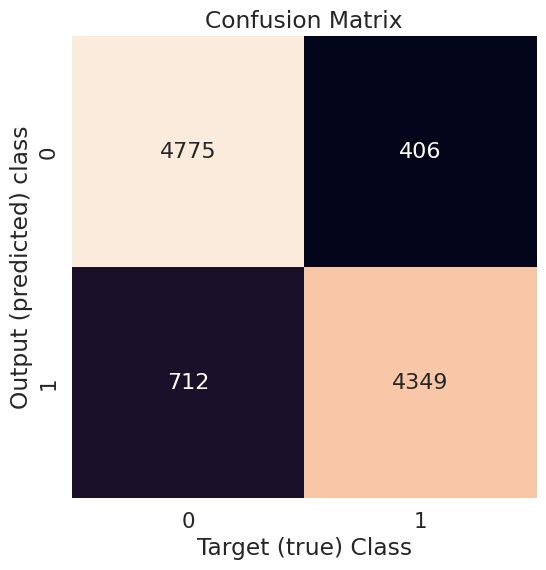

              precision    recall  f1-score   support

       licit       0.87      0.92      0.90      5181
     illicit       0.91      0.86      0.89      5061

    accuracy                           0.89     10242
   macro avg       0.89      0.89      0.89     10242
weighted avg       0.89      0.89      0.89     10242

Epoch   0 | Train Loss: 1.327 | Train Acc:  49.69% | Val Loss: 1.34 | Val Acc: 49.89%
Saving model for best loss
Epoch  10 | Train Loss: 0.464 | Train Acc:  80.90% | Val Loss: 0.45 | Val Acc: 81.36%
Saving model for best loss
Epoch  20 | Train Loss: 0.371 | Train Acc:  85.21% | Val Loss: 0.36 | Val Acc: 86.05%
Saving model for best loss
Epoch  30 | Train Loss: 0.318 | Train Acc:  87.04% | Val Loss: 0.31 | Val Acc: 87.20%
Saving model for best loss
Epoch  40 | Train Loss: 0.283 | Train Acc:  88.33% | Val Loss: 0.28 | Val Acc: 88.38%
Saving model for best loss
Epoch  50 | Train Loss: 0.261 | Train Acc:  89.32% | Val Loss: 0.26 | Val Acc: 89.21%
Saving model for best 

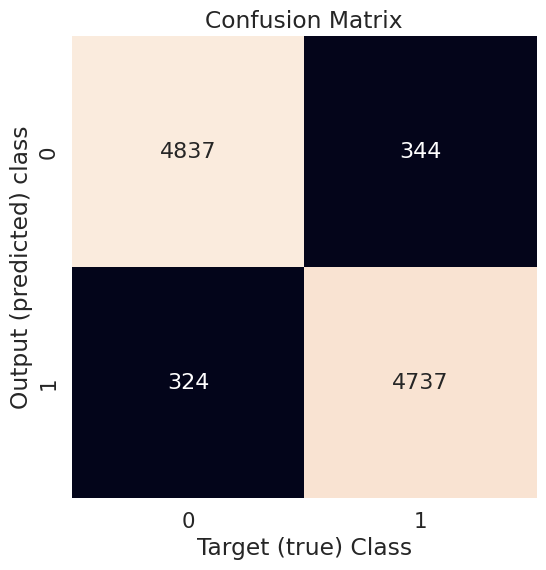

              precision    recall  f1-score   support

       licit       0.94      0.93      0.94      5181
     illicit       0.93      0.94      0.93      5061

    accuracy                           0.93     10242
   macro avg       0.93      0.93      0.93     10242
weighted avg       0.93      0.93      0.93     10242

Epoch   0 | Train Loss: 0.706 | Train Acc:  44.14% | Val Loss: 0.71 | Val Acc: 43.98%
Saving model for best loss
Epoch  10 | Train Loss: 0.508 | Train Acc:  79.95% | Val Loss: 0.50 | Val Acc: 80.64%
Saving model for best loss
Epoch  20 | Train Loss: 0.419 | Train Acc:  83.76% | Val Loss: 0.41 | Val Acc: 84.73%
Saving model for best loss
Epoch  30 | Train Loss: 0.364 | Train Acc:  85.16% | Val Loss: 0.35 | Val Acc: 86.01%
Saving model for best loss
Epoch  40 | Train Loss: 0.330 | Train Acc:  86.08% | Val Loss: 0.32 | Val Acc: 86.73%
Saving model for best loss
Epoch  50 | Train Loss: 0.306 | Train Acc:  87.02% | Val Loss: 0.30 | Val Acc: 87.57%
Saving model for best 

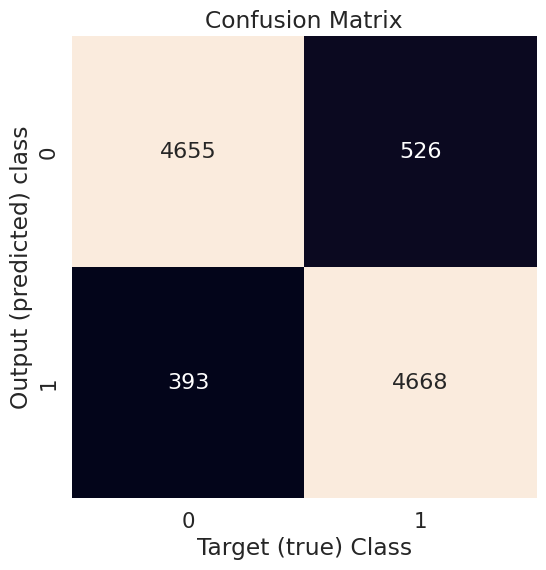

              precision    recall  f1-score   support

       licit       0.92      0.90      0.91      5181
     illicit       0.90      0.92      0.91      5061

    accuracy                           0.91     10242
   macro avg       0.91      0.91      0.91     10242
weighted avg       0.91      0.91      0.91     10242

Epoch   0 | Train Loss: 2.577 | Train Acc:  50.12% | Val Loss: 1.18 | Val Acc: 49.95%
Saving model for best loss
Epoch  10 | Train Loss: 0.811 | Train Acc:  75.66% | Val Loss: 11.70 | Val Acc: 76.04%
Epoch  20 | Train Loss: 0.664 | Train Acc:  79.03% | Val Loss: 0.64 | Val Acc: 79.47%
Saving model for best loss
Epoch  30 | Train Loss: 0.653 | Train Acc:  80.38% | Val Loss: 0.57 | Val Acc: 80.91%
Saving model for best loss
Epoch  40 | Train Loss: 0.571 | Train Acc:  81.63% | Val Loss: 0.55 | Val Acc: 81.76%
Saving model for best loss
Epoch  50 | Train Loss: 0.544 | Train Acc:  82.53% | Val Loss: 0.53 | Val Acc: 83.18%
Saving model for best loss
Epoch  60 | Train Los

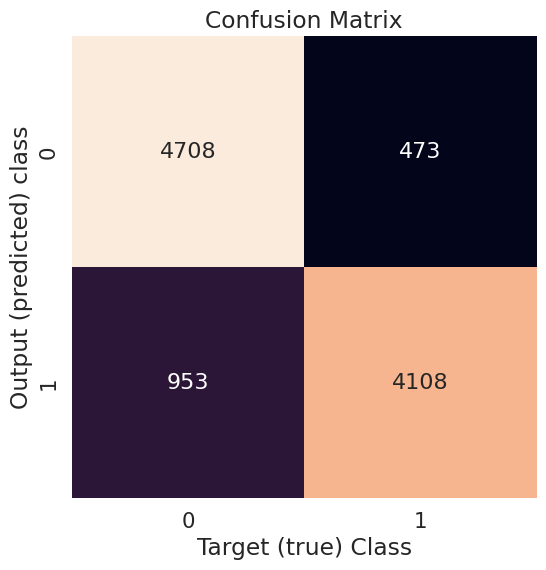

              precision    recall  f1-score   support

       licit       0.83      0.91      0.87      5181
     illicit       0.90      0.81      0.85      5061

    accuracy                           0.86     10242
   macro avg       0.86      0.86      0.86     10242
weighted avg       0.86      0.86      0.86     10242

Epoch   0 | Train Loss: 0.743 | Train Acc:  53.99% | Val Loss: 0.74 | Val Acc: 54.52%
Saving model for best loss
Epoch  10 | Train Loss: 0.458 | Train Acc:  79.04% | Val Loss: 0.44 | Val Acc: 79.70%
Saving model for best loss
Epoch  20 | Train Loss: 0.385 | Train Acc:  83.53% | Val Loss: 0.37 | Val Acc: 84.39%
Saving model for best loss
Epoch  30 | Train Loss: 0.348 | Train Acc:  85.74% | Val Loss: 0.34 | Val Acc: 85.74%
Saving model for best loss
Epoch  40 | Train Loss: 0.320 | Train Acc:  86.99% | Val Loss: 0.31 | Val Acc: 86.93%
Saving model for best loss
Epoch  50 | Train Loss: 0.300 | Train Acc:  87.99% | Val Loss: 0.29 | Val Acc: 88.04%
Saving model for best 

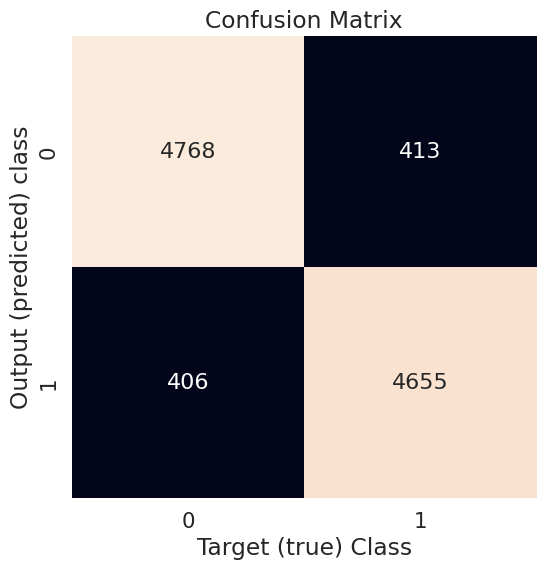

              precision    recall  f1-score   support

       licit       0.92      0.92      0.92      5181
     illicit       0.92      0.92      0.92      5061

    accuracy                           0.92     10242
   macro avg       0.92      0.92      0.92     10242
weighted avg       0.92      0.92      0.92     10242

Epoch   0 | Train Loss: 0.781 | Train Acc:  54.80% | Val Loss: 0.79 | Val Acc: 54.20%
Saving model for best loss
Epoch  10 | Train Loss: 0.445 | Train Acc:  80.05% | Val Loss: 0.43 | Val Acc: 80.56%
Saving model for best loss
Epoch  20 | Train Loss: 0.362 | Train Acc:  85.01% | Val Loss: 0.36 | Val Acc: 85.28%
Saving model for best loss
Epoch  30 | Train Loss: 0.319 | Train Acc:  87.04% | Val Loss: 0.31 | Val Acc: 87.46%
Saving model for best loss
Epoch  40 | Train Loss: 0.293 | Train Acc:  88.13% | Val Loss: 0.29 | Val Acc: 88.35%
Saving model for best loss
Epoch  50 | Train Loss: 0.271 | Train Acc:  89.04% | Val Loss: 0.27 | Val Acc: 89.13%
Saving model for best 

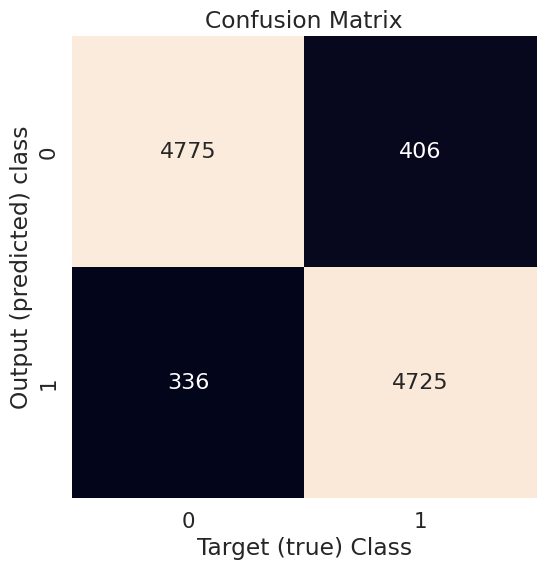

              precision    recall  f1-score   support

       licit       0.93      0.92      0.93      5181
     illicit       0.92      0.93      0.93      5061

    accuracy                           0.93     10242
   macro avg       0.93      0.93      0.93     10242
weighted avg       0.93      0.93      0.93     10242

Epoch   0 | Train Loss: 1.091 | Train Acc:  41.54% | Val Loss: 1.11 | Val Acc: 40.87%
Saving model for best loss
Epoch  10 | Train Loss: 0.526 | Train Acc:  75.73% | Val Loss: 0.50 | Val Acc: 76.58%
Saving model for best loss
Epoch  20 | Train Loss: 0.420 | Train Acc:  82.35% | Val Loss: 0.41 | Val Acc: 82.44%
Saving model for best loss
Epoch  30 | Train Loss: 0.373 | Train Acc:  84.89% | Val Loss: 0.36 | Val Acc: 85.08%
Saving model for best loss
Epoch  40 | Train Loss: 0.348 | Train Acc:  85.75% | Val Loss: 0.34 | Val Acc: 85.61%
Saving model for best loss
Epoch  50 | Train Loss: 0.328 | Train Acc:  86.60% | Val Loss: 0.31 | Val Acc: 87.33%
Saving model for best 

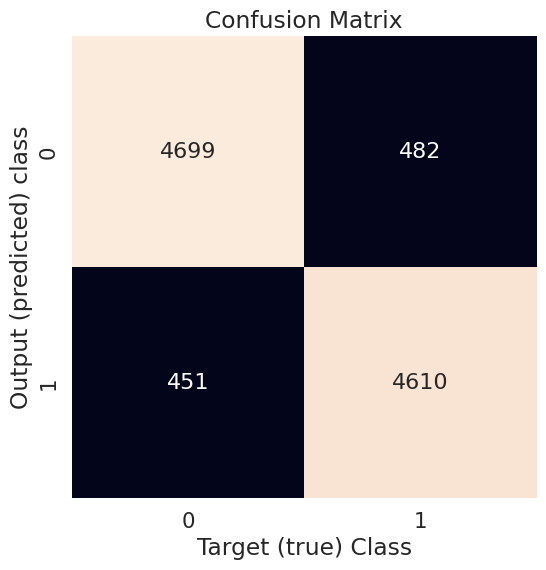

              precision    recall  f1-score   support

       licit       0.91      0.91      0.91      5181
     illicit       0.91      0.91      0.91      5061

    accuracy                           0.91     10242
   macro avg       0.91      0.91      0.91     10242
weighted avg       0.91      0.91      0.91     10242

Epoch   0 | Train Loss: 0.686 | Train Acc:  52.86% | Val Loss: 0.69 | Val Acc: 52.29%
Saving model for best loss
Epoch  10 | Train Loss: 0.592 | Train Acc:  85.15% | Val Loss: 0.59 | Val Acc: 85.45%
Saving model for best loss
Epoch  20 | Train Loss: 0.575 | Train Acc:  88.38% | Val Loss: 0.58 | Val Acc: 88.27%
Saving model for best loss
Epoch  30 | Train Loss: 0.562 | Train Acc:  90.84% | Val Loss: 0.56 | Val Acc: 90.95%
Saving model for best loss
Epoch  40 | Train Loss: 0.550 | Train Acc:  92.47% | Val Loss: 0.55 | Val Acc: 92.41%
Saving model for best loss
Epoch  50 | Train Loss: 0.539 | Train Acc:  93.61% | Val Loss: 0.54 | Val Acc: 93.51%
Saving model for best 

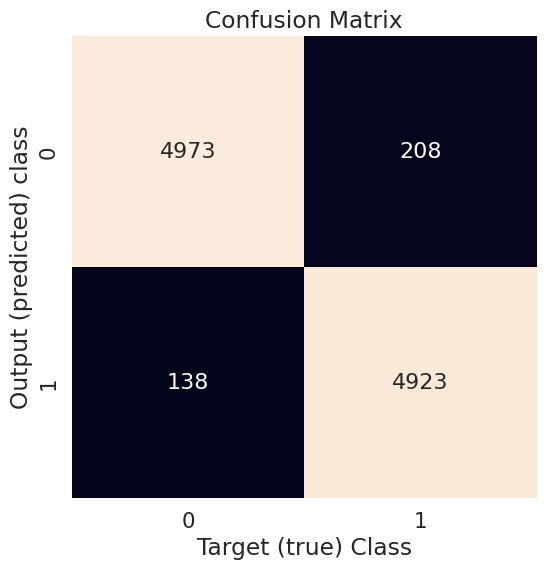

              precision    recall  f1-score   support

       licit       0.97      0.96      0.97      5181
     illicit       0.96      0.97      0.97      5061

    accuracy                           0.97     10242
   macro avg       0.97      0.97      0.97     10242
weighted avg       0.97      0.97      0.97     10242

Epoch   0 | Train Loss: 0.728 | Train Acc:  41.84% | Val Loss: 0.73 | Val Acc: 42.82%
Saving model for best loss
Epoch  10 | Train Loss: 0.484 | Train Acc:  80.21% | Val Loss: 0.49 | Val Acc: 80.77%
Saving model for best loss
Epoch  20 | Train Loss: 0.397 | Train Acc:  84.93% | Val Loss: 0.41 | Val Acc: 85.39%
Saving model for best loss
Epoch  30 | Train Loss: 0.342 | Train Acc:  86.97% | Val Loss: 0.36 | Val Acc: 86.92%
Saving model for best loss
Epoch  40 | Train Loss: 0.306 | Train Acc:  87.83% | Val Loss: 0.32 | Val Acc: 87.98%
Saving model for best loss
Epoch  50 | Train Loss: 0.281 | Train Acc:  88.77% | Val Loss: 0.30 | Val Acc: 88.85%
Saving model for best 

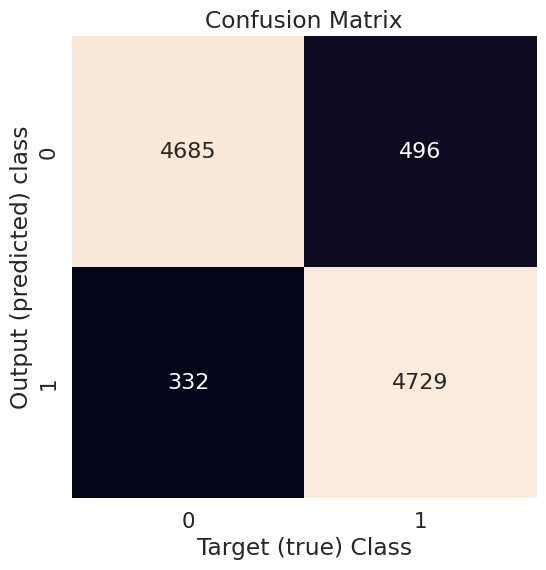

              precision    recall  f1-score   support

       licit       0.93      0.90      0.92      5181
     illicit       0.91      0.93      0.92      5061

    accuracy                           0.92     10242
   macro avg       0.92      0.92      0.92     10242
weighted avg       0.92      0.92      0.92     10242

Epoch   0 | Train Loss: 0.789 | Train Acc:  44.46% | Val Loss: 0.80 | Val Acc: 44.26%
Saving model for best loss
Epoch  10 | Train Loss: 0.511 | Train Acc:  80.27% | Val Loss: 0.51 | Val Acc: 80.89%
Saving model for best loss
Epoch  20 | Train Loss: 0.421 | Train Acc:  84.86% | Val Loss: 0.42 | Val Acc: 85.12%
Saving model for best loss
Epoch  30 | Train Loss: 0.360 | Train Acc:  86.62% | Val Loss: 0.36 | Val Acc: 86.66%
Saving model for best loss
Epoch  40 | Train Loss: 0.322 | Train Acc:  87.36% | Val Loss: 0.33 | Val Acc: 87.65%
Saving model for best loss
Epoch  50 | Train Loss: 0.295 | Train Acc:  88.20% | Val Loss: 0.31 | Val Acc: 88.34%
Saving model for best 

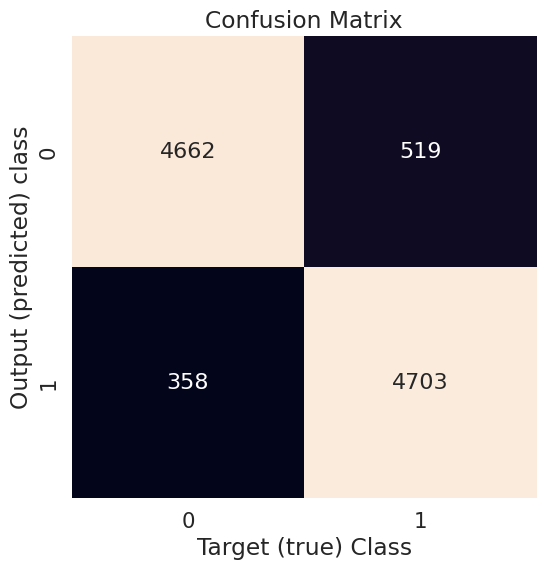

              precision    recall  f1-score   support

       licit       0.93      0.90      0.91      5181
     illicit       0.90      0.93      0.91      5061

    accuracy                           0.91     10242
   macro avg       0.91      0.91      0.91     10242
weighted avg       0.91      0.91      0.91     10242

Epoch   0 | Train Loss: 0.798 | Train Acc:  39.08% | Val Loss: 0.80 | Val Acc: 38.69%
Saving model for best loss
Epoch  10 | Train Loss: 0.609 | Train Acc:  67.39% | Val Loss: 0.61 | Val Acc: 67.19%
Saving model for best loss
Epoch  20 | Train Loss: 0.583 | Train Acc:  68.81% | Val Loss: 0.58 | Val Acc: 68.97%
Saving model for best loss
Epoch  30 | Train Loss: 0.570 | Train Acc:  70.03% | Val Loss: 0.57 | Val Acc: 70.13%
Saving model for best loss
Epoch  40 | Train Loss: 0.561 | Train Acc:  70.50% | Val Loss: 0.56 | Val Acc: 70.46%
Saving model for best loss
Epoch  50 | Train Loss: 0.554 | Train Acc:  70.87% | Val Loss: 0.55 | Val Acc: 70.81%
Saving model for best 

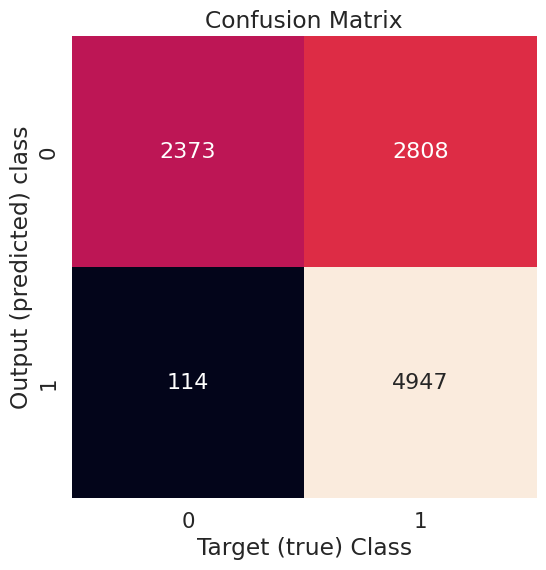

              precision    recall  f1-score   support

       licit       0.95      0.46      0.62      5181
     illicit       0.64      0.98      0.77      5061

    accuracy                           0.71     10242
   macro avg       0.80      0.72      0.70     10242
weighted avg       0.80      0.71      0.69     10242

Epoch   0 | Train Loss: 2.275 | Train Acc:  55.33% | Val Loss: 1.65 | Val Acc: 55.13%
Saving model for best loss
Epoch  10 | Train Loss: 0.535 | Train Acc:  80.53% | Val Loss: 0.84 | Val Acc: 81.12%
Saving model for best loss
Epoch  20 | Train Loss: 0.455 | Train Acc:  84.95% | Val Loss: 0.83 | Val Acc: 85.37%
Saving model for best loss
Epoch  30 | Train Loss: 0.388 | Train Acc:  86.54% | Val Loss: 0.44 | Val Acc: 87.16%
Saving model for best loss
Epoch  40 | Train Loss: 0.330 | Train Acc:  87.56% | Val Loss: 0.44 | Val Acc: 87.98%
Epoch  50 | Train Loss: 0.300 | Train Acc:  88.41% | Val Loss: 0.53 | Val Acc: 88.52%
Epoch  60 | Train Loss: 0.276 | Train Acc:  89.06

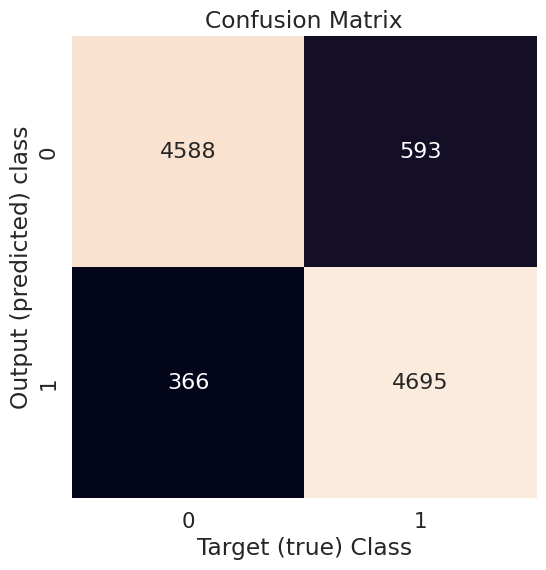

              precision    recall  f1-score   support

       licit       0.93      0.89      0.91      5181
     illicit       0.89      0.93      0.91      5061

    accuracy                           0.91     10242
   macro avg       0.91      0.91      0.91     10242
weighted avg       0.91      0.91      0.91     10242

Epoch   0 | Train Loss: 0.716 | Train Acc:  42.35% | Val Loss: 0.72 | Val Acc: 42.41%
Saving model for best loss
Epoch  10 | Train Loss: 0.471 | Train Acc:  82.39% | Val Loss: 0.47 | Val Acc: 83.02%
Saving model for best loss
Epoch  20 | Train Loss: 0.377 | Train Acc:  86.00% | Val Loss: 0.38 | Val Acc: 86.52%
Saving model for best loss
Epoch  30 | Train Loss: 0.320 | Train Acc:  87.56% | Val Loss: 0.32 | Val Acc: 87.49%
Saving model for best loss
Epoch  40 | Train Loss: 0.285 | Train Acc:  88.27% | Val Loss: 0.28 | Val Acc: 88.59%
Saving model for best loss
Epoch  50 | Train Loss: 0.261 | Train Acc:  89.31% | Val Loss: 0.27 | Val Acc: 89.31%
Saving model for best 

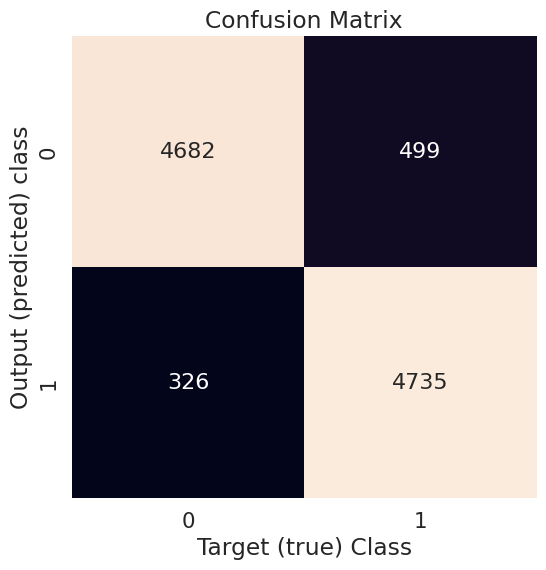

              precision    recall  f1-score   support

       licit       0.93      0.90      0.92      5181
     illicit       0.90      0.94      0.92      5061

    accuracy                           0.92     10242
   macro avg       0.92      0.92      0.92     10242
weighted avg       0.92      0.92      0.92     10242

Epoch   0 | Train Loss: 0.738 | Train Acc:  44.46% | Val Loss: 0.74 | Val Acc: 43.89%
Saving model for best loss
Epoch  10 | Train Loss: 0.490 | Train Acc:  80.86% | Val Loss: 0.49 | Val Acc: 81.76%
Saving model for best loss
Epoch  20 | Train Loss: 0.400 | Train Acc:  85.05% | Val Loss: 0.40 | Val Acc: 85.19%
Saving model for best loss
Epoch  30 | Train Loss: 0.341 | Train Acc:  87.00% | Val Loss: 0.34 | Val Acc: 87.39%
Saving model for best loss
Epoch  40 | Train Loss: 0.305 | Train Acc:  88.15% | Val Loss: 0.32 | Val Acc: 88.10%
Saving model for best loss
Epoch  50 | Train Loss: 0.280 | Train Acc:  88.96% | Val Loss: 0.29 | Val Acc: 88.93%
Saving model for best 

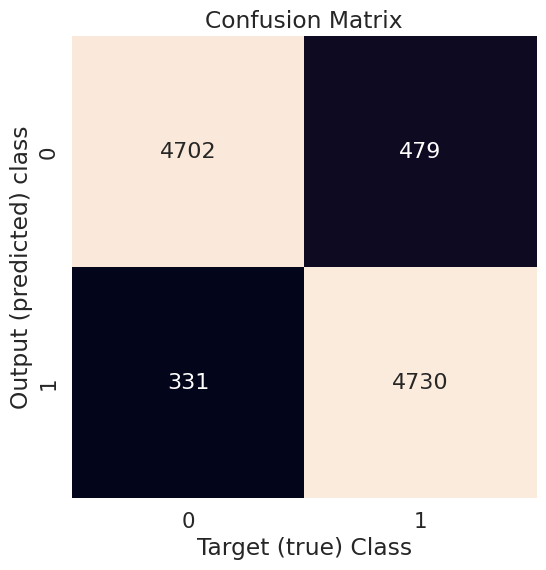

              precision    recall  f1-score   support

       licit       0.93      0.91      0.92      5181
     illicit       0.91      0.93      0.92      5061

    accuracy                           0.92     10242
   macro avg       0.92      0.92      0.92     10242
weighted avg       0.92      0.92      0.92     10242

Epoch   0 | Train Loss: 0.683 | Train Acc:  52.59% | Val Loss: 0.68 | Val Acc: 52.59%
Saving model for best loss
Epoch  10 | Train Loss: 0.472 | Train Acc:  82.13% | Val Loss: 0.47 | Val Acc: 82.71%
Saving model for best loss
Epoch  20 | Train Loss: 0.383 | Train Acc:  85.55% | Val Loss: 0.38 | Val Acc: 86.02%
Saving model for best loss
Epoch  30 | Train Loss: 0.329 | Train Acc:  86.91% | Val Loss: 0.32 | Val Acc: 87.30%
Saving model for best loss
Epoch  40 | Train Loss: 0.295 | Train Acc:  88.06% | Val Loss: 0.29 | Val Acc: 88.14%
Saving model for best loss
Epoch  50 | Train Loss: 0.273 | Train Acc:  88.84% | Val Loss: 0.27 | Val Acc: 89.08%
Saving model for best 

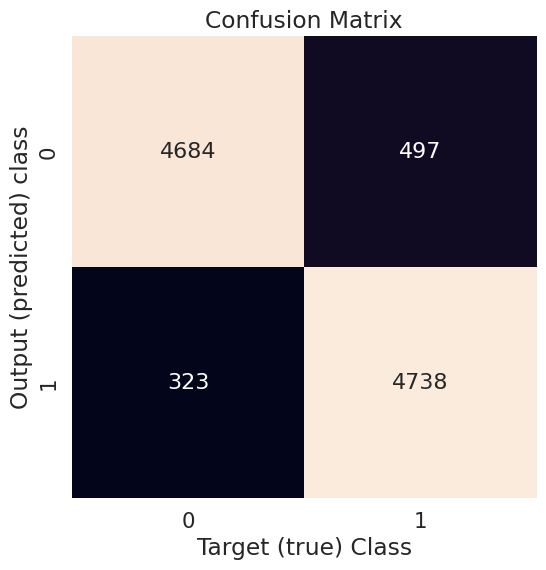

              precision    recall  f1-score   support

       licit       0.94      0.90      0.92      5181
     illicit       0.91      0.94      0.92      5061

    accuracy                           0.92     10242
   macro avg       0.92      0.92      0.92     10242
weighted avg       0.92      0.92      0.92     10242

Epoch   0 | Train Loss: 0.674 | Train Acc:  51.67% | Val Loss: 0.67 | Val Acc: 52.19%
Saving model for best loss
Epoch  10 | Train Loss: 0.487 | Train Acc:  80.75% | Val Loss: 0.48 | Val Acc: 81.62%
Saving model for best loss
Epoch  20 | Train Loss: 0.412 | Train Acc:  83.98% | Val Loss: 0.40 | Val Acc: 84.87%
Saving model for best loss
Epoch  30 | Train Loss: 0.366 | Train Acc:  85.60% | Val Loss: 0.35 | Val Acc: 86.30%
Saving model for best loss
Epoch  40 | Train Loss: 0.336 | Train Acc:  86.52% | Val Loss: 0.33 | Val Acc: 86.98%
Saving model for best loss
Epoch  50 | Train Loss: 0.314 | Train Acc:  87.30% | Val Loss: 0.30 | Val Acc: 87.83%
Saving model for best 

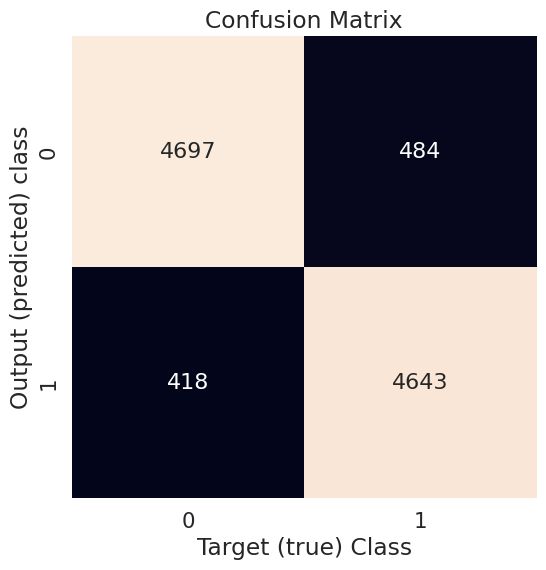

              precision    recall  f1-score   support

       licit       0.92      0.91      0.91      5181
     illicit       0.91      0.92      0.91      5061

    accuracy                           0.91     10242
   macro avg       0.91      0.91      0.91     10242
weighted avg       0.91      0.91      0.91     10242

Epoch   0 | Train Loss: 1.141 | Train Acc:  52.04% | Val Loss: 1.17 | Val Acc: 51.64%
Saving model for best loss
Epoch  10 | Train Loss: 0.553 | Train Acc:  74.28% | Val Loss: 0.54 | Val Acc: 75.34%
Saving model for best loss
Epoch  20 | Train Loss: 0.418 | Train Acc:  81.83% | Val Loss: 0.41 | Val Acc: 82.39%
Saving model for best loss
Epoch  30 | Train Loss: 0.369 | Train Acc:  84.49% | Val Loss: 0.36 | Val Acc: 84.72%
Saving model for best loss
Epoch  40 | Train Loss: 0.338 | Train Acc:  85.75% | Val Loss: 0.33 | Val Acc: 86.09%
Saving model for best loss
Epoch  50 | Train Loss: 0.316 | Train Acc:  86.69% | Val Loss: 0.31 | Val Acc: 87.03%
Saving model for best 

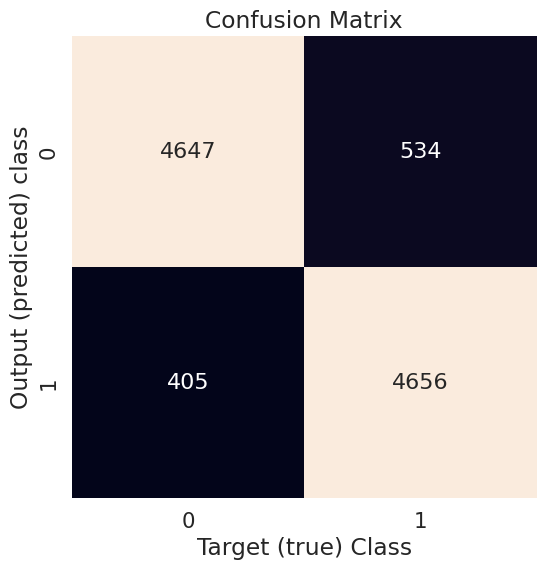

              precision    recall  f1-score   support

       licit       0.92      0.90      0.91      5181
     illicit       0.90      0.92      0.91      5061

    accuracy                           0.91     10242
   macro avg       0.91      0.91      0.91     10242
weighted avg       0.91      0.91      0.91     10242

Epoch   0 | Train Loss: 0.772 | Train Acc:  53.09% | Val Loss: 0.77 | Val Acc: 53.08%
Saving model for best loss
Epoch  10 | Train Loss: 0.511 | Train Acc:  77.70% | Val Loss: 0.51 | Val Acc: 78.55%
Saving model for best loss
Epoch  20 | Train Loss: 0.418 | Train Acc:  83.14% | Val Loss: 0.41 | Val Acc: 83.74%
Saving model for best loss
Epoch  30 | Train Loss: 0.363 | Train Acc:  85.39% | Val Loss: 0.35 | Val Acc: 86.08%
Saving model for best loss
Epoch  40 | Train Loss: 0.329 | Train Acc:  86.52% | Val Loss: 0.32 | Val Acc: 86.98%
Saving model for best loss
Epoch  50 | Train Loss: 0.305 | Train Acc:  87.33% | Val Loss: 0.30 | Val Acc: 87.97%
Saving model for best 

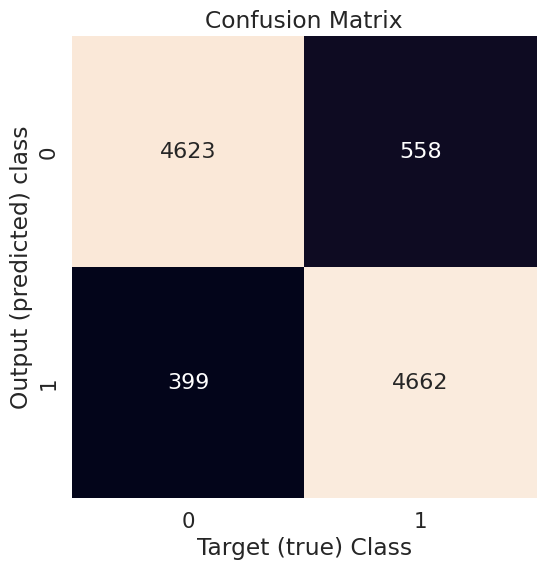

              precision    recall  f1-score   support

       licit       0.92      0.89      0.91      5181
     illicit       0.89      0.92      0.91      5061

    accuracy                           0.91     10242
   macro avg       0.91      0.91      0.91     10242
weighted avg       0.91      0.91      0.91     10242

Epoch   0 | Train Loss: 0.670 | Train Acc:  58.36% | Val Loss: 0.67 | Val Acc: 58.13%
Saving model for best loss
Epoch  10 | Train Loss: 0.460 | Train Acc:  82.04% | Val Loss: 0.45 | Val Acc: 82.54%
Saving model for best loss
Epoch  20 | Train Loss: 0.374 | Train Acc:  86.14% | Val Loss: 0.37 | Val Acc: 86.43%
Saving model for best loss
Epoch  30 | Train Loss: 0.325 | Train Acc:  87.40% | Val Loss: 0.32 | Val Acc: 87.41%
Saving model for best loss
Epoch  40 | Train Loss: 0.294 | Train Acc:  88.35% | Val Loss: 0.29 | Val Acc: 88.64%
Saving model for best loss
Epoch  50 | Train Loss: 0.270 | Train Acc:  89.19% | Val Loss: 0.27 | Val Acc: 89.04%
Saving model for best 

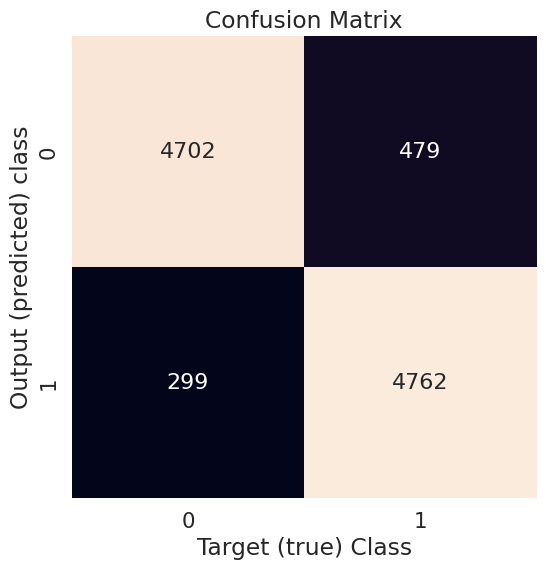

              precision    recall  f1-score   support

       licit       0.94      0.91      0.92      5181
     illicit       0.91      0.94      0.92      5061

    accuracy                           0.92     10242
   macro avg       0.92      0.92      0.92     10242
weighted avg       0.92      0.92      0.92     10242

Finalizado.



In [98]:
# BUCLE PARA PROBAR TODOS LOS MODELOS

import torch_geometric.nn.conv as conv
import inspect

# Obtenemos todas las clases del módulo conv
conv_classes = inspect.getmembers(conv, inspect.isclass)


# Seleccionamos sólo las clases que heredan de torch.nn.Module y tienen un método forward, para simplificar
conv_layers = [layer[1] for layer in conv_classes if issubclass(layer[1], torch.nn.Module) and
               hasattr(layer[1], 'forward') and
               'in_channels' in inspect.signature(layer[1].__init__).parameters and
               'out_channels' in inspect.signature(layer[1].__init__).parameters]

conv_layers = [layer[1] for layer in conv_classes if issubclass(layer[1], torch.nn.Module) and
               hasattr(layer[1], 'forward') ]

layers_not_used = []
reports = {}

#Preparamos DF de metricas
df = pd.DataFrame(columns=['GNN model', 'precision', 'recall', 'f1score', 'f1_macroavg'])
df_class = pd.DataFrame(columns=['GNN model', 'precision', 'recall', 'f1score', 'f1_macroavg'])


# Creamos un modelo con cada capa convolucional de la lista
for conv_layer in conv_layers:

    try:

      # Instanciamos GeneralGNN
      model = GeneralGNN(Config.input_dim, Config.hidden_size, Config.output_dim, conv_layer, Config.num_layers).to(Config.device)

      data_train = elliptic_dataset.to(Config.device)

      optimizer = torch.optim.Adam(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
      criterion = torch.nn.BCEWithLogitsLoss()

      # Entrenamos y evaluamos el modelo
      train_evaluate(model,
              data_train,
              criterion,
              optimizer,
              Config.num_epochs,
              Config.checkpoints_dir,
              type(conv_layer).__name__ + '.pth.tar')

      # Mostramos estructura
      print(model)
      model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, type(conv_layer).__name__ + '.pth.tar'))['state_dict'])

      y_test_preds = test(model, data_train)

      # confusion matrix on validation data
      conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx].cpu().numpy())

      # impresión matriz de confusión
      plt.subplots(figsize=(6,6))
      sns.set(font_scale=1.4)
      sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
      plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
      plt.show();


      res = classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                                  y_test_preds[valid_idx].cpu().numpy(),
                                  target_names=['licit', 'illicit'])
      # Mostramos resultados
      print (res)

      # Guardamos resultados para la tabla comparativa
      precision = res[128:132]
      recall = res[138:142]
      f1score = res[148:152]
      f1_macroavg = res[257:261]
      df = df.append({'GNN model': conv_layer.__name__, 'precision': precision, 'recall': recall, 'f1score': f1score, 'f1_macroavg': f1_macroavg}, ignore_index=True)
      df_class = df_class.append({'GNN model': conv_layer, 'precision': precision, 'recall': recall, 'f1score': f1score, 'f1_macroavg': f1_macroavg}, ignore_index=True)
      reports[conv_layer] = res


    except Exception as e:
      #print(f"Error: {e}. Skipping item: {conv_layer}")
      layers_not_used.append(conv_layer)
      continue

print("Finalizado.\n")




In [99]:
# Mostramos tabla comparativa ordenada por f1 macro avg
df_class = df_class.sort_values(by=['f1_macroavg'], ascending=False).reset_index(drop=True)
print(df.sort_values(by=['f1_macroavg'], ascending=False).reset_index(drop=True))


            GNN model precision recall f1score f1_macroavg
0             GENConv      0.96   0.97    0.97        0.97
1           GATv2Conv      0.92   0.93    0.93        0.93
2      ClusterGCNConv      0.93   0.94    0.93        0.93
3     TransformerConv      0.91   0.94    0.92        0.92
4              MFConv      0.90   0.94    0.92        0.92
5             GATConv      0.92   0.92    0.92        0.92
6         GeneralConv      0.91   0.93    0.92        0.92
7            SAGEConv      0.91   0.94    0.92        0.92
8   ResGatedGraphConv      0.91   0.93    0.92        0.92
9             TAGConv      0.89   0.92    0.91        0.91
10       SuperGATConv      0.90   0.92    0.91        0.91
11             SGConv      0.91   0.92    0.91        0.91
12          GraphConv      0.90   0.93    0.91        0.91
13             LEConv      0.89   0.93    0.91        0.91
14            GCNConv      0.91   0.91    0.91        0.91
15          FeaStConv      0.90   0.92    0.91        0.

In [100]:
# Adaptación al GeneralGNN pero con 3 modelos como argumentos de entrada
class GeneralGNNTop3(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out, model1, model2, model3, num_layers=3):
        super(GeneralGNNTop3, self).__init__()

        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        self.layers.append(model1(in_channels=dim_in, out_channels=dim_h))

        if self.num_layers > 2:
          for i in range(1,self.num_layers-1,1):
              layer = model2(in_channels=dim_h, out_channels=dim_h)
              self.layers.append(layer)

        layer = model3(in_channels=dim_h, out_channels=dim_out)
        self.layers.append(layer)

    def forward(self, x, edge_index):

        for i in range(0,self.num_layers-1,1):
          h = self.layers[0](x, edge_index)
          h = torch.relu(h)
          h = F.dropout(h, p=0.6, training=self.training)


        out = self.layers[len(self.layers)-1](h, edge_index)
        return out

    def get_num_layers(self):
      return len(self.layers)

Epoch   0 | Train Loss: 0.769 | Train Acc:  51.44% | Val Loss: 0.77 | Val Acc: 51.21%
Saving model for best loss
Epoch  10 | Train Loss: 0.288 | Train Acc:  88.78% | Val Loss: 0.28 | Val Acc: 88.79%
Saving model for best loss
Epoch  20 | Train Loss: 0.208 | Train Acc:  91.78% | Val Loss: 0.21 | Val Acc: 91.82%
Saving model for best loss
Epoch  30 | Train Loss: 0.167 | Train Acc:  93.59% | Val Loss: 0.17 | Val Acc: 93.40%
Saving model for best loss
Epoch  40 | Train Loss: 0.140 | Train Acc:  94.72% | Val Loss: 0.14 | Val Acc: 94.64%
Saving model for best loss
Epoch  50 | Train Loss: 0.118 | Train Acc:  95.65% | Val Loss: 0.12 | Val Acc: 95.55%
Saving model for best loss
Epoch  60 | Train Loss: 0.102 | Train Acc:  96.36% | Val Loss: 0.11 | Val Acc: 96.05%
Saving model for best loss
Epoch  70 | Train Loss: 0.086 | Train Acc:  96.97% | Val Loss: 0.09 | Val Acc: 96.52%
Saving model for best loss
Epoch  80 | Train Loss: 0.073 | Train Acc:  97.46% | Val Loss: 0.09 | Val Acc: 96.81%
Saving mod

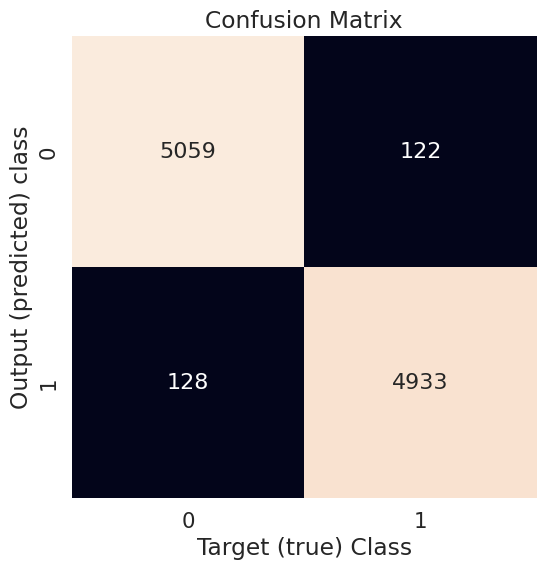

              precision    recall  f1-score   support

       licit       0.98      0.98      0.98      5181
     illicit       0.98      0.97      0.98      5061

    accuracy                           0.98     10242
   macro avg       0.98      0.98      0.98     10242
weighted avg       0.98      0.98      0.98     10242

Finalizado.



In [101]:

#Combinamos los tres mejores
model = GeneralGNNTop3(Config.input_dim, Config.hidden_size, Config.output_dim, df_class['GNN model'][0], df_class['GNN model'][1], df_class['GNN model'][2], 3).to(Config.device)

data_train = elliptic_dataset.to(Config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()
train_evaluate(model,
        data_train,
        criterion,
        optimizer,
        Config.num_epochs,
        Config.checkpoints_dir,
        type(conv_layer).__name__ + '.pth.tar')

print(model)
model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, type(df_class['GNN model'][0]).__name__ + '.pth.tar'))['state_dict'])

y_test_preds = test(model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx].cpu().numpy())

# impresión matriz de confusión
plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();


res = classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx].cpu().numpy(),
                            target_names=['licit', 'illicit'])

print(res)


print("Finalizado.\n")